Transformer_VAE 모델
예상
VAE모델에 self_attention 메커니즘의 Multi_Head 구조를 이용해서 각 변수들의 비선형적인 관계를 더 잘 파악할 수 있을 거라 생각했음.
결과
총 24개 하이퍼파라미터 조합으로 3-Fold 교차 검증을 돌려보니, 검증 데이터에서 최대 0.9406의 평균 AUC Score를 달성함.
제일 좋은 하이퍼파라미터(latent_dim=4, learning_rate=0.001, beta_max=0.01, free_bits=0.1)로 최종 모델을 학습시켜서 테스트 데이터로 평가해 보니 재구성 오차(MSE) 0.1327, 최종 AUC Score 0.9334라는 아주 높은 이상치 탐지 성능을 기록함.
결론
최종 모델이 테스트 데이터에서 0.93 넘는 높은 AUC Score를 찍었다는 건, attention 메커니즘이 데이터 특성들 사이의 복잡하고 비선형적인 관계를 제대로 학습했다는 걸 보여줌. 그래서 VAE에 attention을 붙이는 게 이상치 탐지 성능을 높이는 데 아주 효과적이라는 처음 예상을 실험으로 증명했음.

한글 폰트 설정 완료.
compute_pca_weights ===== K-Fold Training with Early Stopping (Improved VAE) =====
평가할 조합 수: 24

--- 조합 1/24 평가 중: {'hidden_dim': 128, 'latent_dim': 2, 'learning_rate': 0.001, 'beta_max': 0.01, 'free_bits': 0.0} ---
--- Fold 1 / 3 ---
Epoch [10/500] Train Loss: 5.3958, Val Loss: 4.8465, Beta: 0.0015
Epoch [20/500] Train Loss: 5.0670, Val Loss: 4.5186, Beta: 0.0031
Epoch [30/500] Train Loss: 4.9018, Val Loss: 4.3420, Beta: 0.0047
Epoch [40/500] Train Loss: 4.7938, Val Loss: 4.1965, Beta: 0.0063
Epoch [50/500] Train Loss: 4.7239, Val Loss: 4.1048, Beta: 0.0079
Epoch [60/500] Train Loss: 4.6425, Val Loss: 4.0289, Beta: 0.0095
Epoch [70/500] Train Loss: 4.6463, Val Loss: 4.0796, Beta: 0.0100
Epoch [80/500] Train Loss: 4.6488, Val Loss: 4.0002, Beta: 0.0100
Epoch [90/500] Train Loss: 4.6310, Val Loss: 3.9369, Beta: 0.0100
Epoch [100/500] Train Loss: 4.5320, Val Loss: 3.9458, Beta: 0.0100
Epoch [110/500] Train Loss: 4.6228, Val Loss: 3.9467, Beta: 0.0100
Epoch [120/500] Train Lo

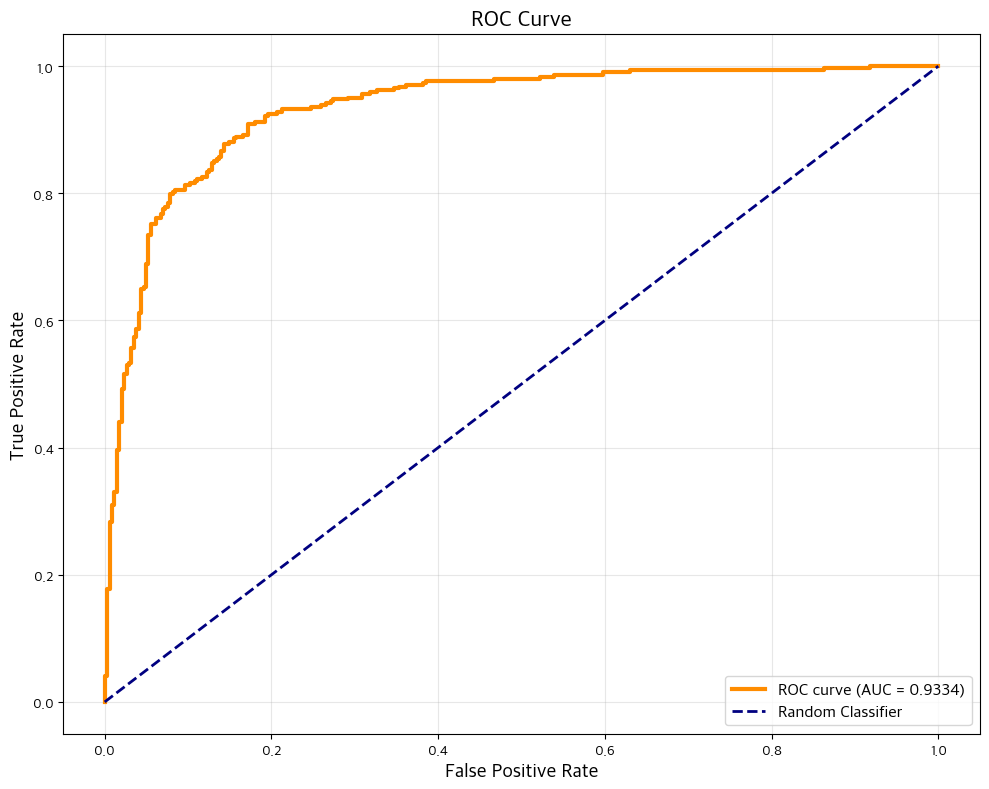

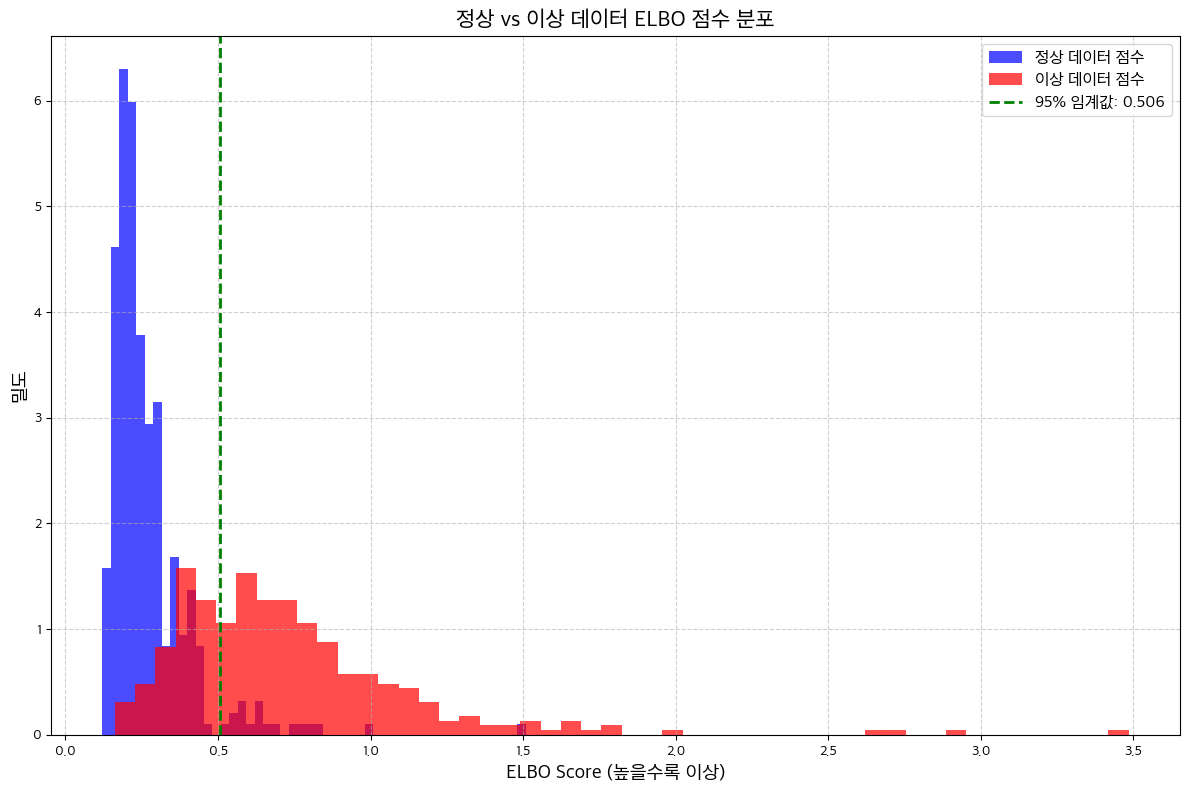

/var/folders/9g/km8p2t5105l95qr48nycb7xh0000gn/T/ipykernel_49120/1844513560.py:418: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Apple SD Gothic Neo.
  plt.tight_layout()
/var/folders/9g/km8p2t5105l95qr48nycb7xh0000gn/T/ipykernel_49120/1844513560.py:419: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Apple SD Gothic Neo.
  plt.savefig("latent_space_visualization.png", dpi=300, bbox_inches='tight')
/opt/homebrew/Caskroom/miniforge/base/envs/311/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Apple SD Gothic Neo.
  fig.canvas.print_figure(bytes_io, **kw)


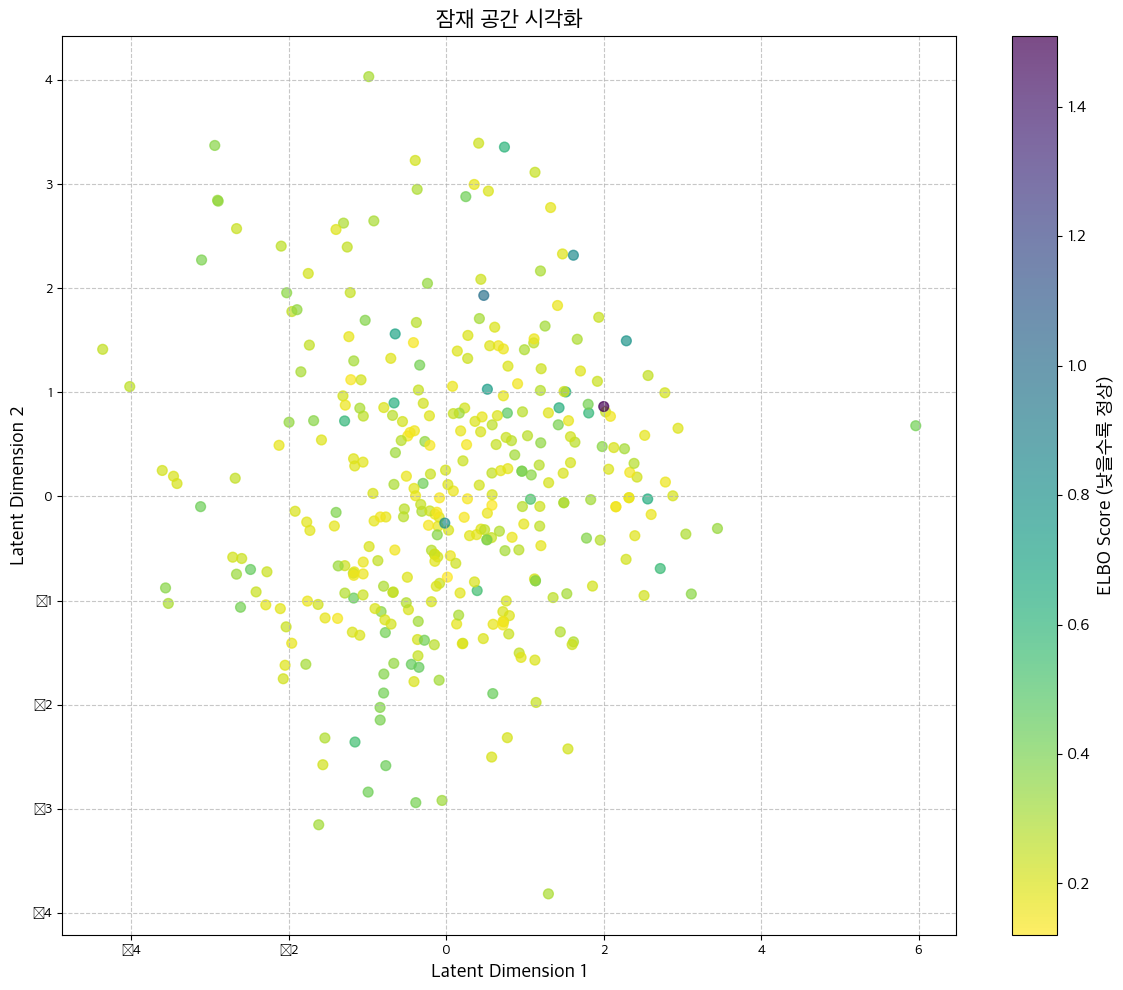


최종 모델과 전처리기, 최적 파라미터가 './develop/' 폴더에 저장되었습니다.


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import joblib
from itertools import product
import os
import time

try:
    font_name = fm.FontProperties(fname="/System/Library/Fonts/AppleSDGothicNeo.ttc", size=12).get_name()
    plt.rc('font', family=font_name)
    print("한글 폰트 설정 완료.")
except FileNotFoundError:
    print("한글 폰트를 찾을 수 없습니다. 영문으로 표시됩니다.")

file_path = "../data/final_fish_data.csv"
df = pd.read_csv(file_path)

imputer = SimpleImputer(strategy="mean")

df["tmp_x_sea_temp"] = df["weather_TMP"] * df["matched_sea_temp"]
df["ws_x_wh_sig"] = df["ws"] * df["wh_sig"]
df['mul_tte_code'] = df['mul_tte_code'].replace(-1, 0)
df['mul_tte_code_sin'] = np.sin(2 * np.pi * df['mul_tte_code'] / 14)
df['mul_tte_code_cos'] = np.cos(2 * np.pi * df['mul_tte_code'] / 14)
df['fishing_datetime'] = pd.to_datetime(df['fishing_datetime_utc'])
df['month'] = df['fishing_datetime'].dt.month
df['hour'] = df['fishing_datetime'].dt.hour
df['season'] = df['month'].apply(lambda x: 1 if 3 <= x <= 5 else 2 if 6 <= x <= 8 else 3 if 9 <= x <= 11 else 4)
df['season_sin'] = np.sin(2 * np.pi * df['season'] / 4)
df['season_cos'] = np.cos(2 * np.pi * df['season'] / 4)
df['time_period'] = df['hour'].apply(lambda x: 0 if 0 <= x < 6 else 1 if 6 <= x < 12 else 2 if 12 <= x < 18 else 3)
df['time_period_sin'] = np.sin(2 * np.pi * df['time_period'] / 4)
df['time_period_cos'] = np.cos(2 * np.pi * df['time_period'] / 4)

feature_cols = [
    "tmp_x_sea_temp", "ws_x_wh_sig", "weather_REH", "wvprd_max", "wvdr", "wd",
    'time_period_sin', 'time_period_cos', 'season_sin', 'season_cos'
]
df_features = df[feature_cols].copy()
X_raw = df_features.values.astype(np.float32)
X_filled = imputer.fit_transform(X_raw)

X_trainval, X_test = train_test_split(X_filled, test_size=0.05, random_state=42, shuffle=True)
scaler = StandardScaler()
X_trainval_scaled = scaler.fit_transform(X_trainval)
X_test_scaled = scaler.transform(X_test)

class CyclicKLAnnealing:
    def __init__(self, n_cycles=4, ratio=0.5):
        self.n_cycles, self.ratio = n_cycles, ratio
    def get_beta(self, epoch, max_epochs, max_beta=1.0, min_beta=0.0):
        cycle_length = max_epochs // self.n_cycles
        cycle_position = epoch % cycle_length
        annealing_length = int(cycle_length * self.ratio)
        return min_beta + (max_beta - min_beta) * (cycle_position / annealing_length) if cycle_position < annealing_length else max_beta

class ImprovedVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, dropout_rate=0.3):
        super(ImprovedVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), nn.BatchNorm1d(hidden_dim), nn.LeakyReLU(0.2), nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim * 2), nn.BatchNorm1d(hidden_dim * 2), nn.LeakyReLU(0.2), nn.Dropout(dropout_rate)
        )
        self.fc_mu, self.fc_logvar = nn.Linear(hidden_dim * 2, latent_dim), nn.Linear(hidden_dim * 2, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim * 2), nn.BatchNorm1d(hidden_dim * 2), nn.LeakyReLU(0.2), nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim * 2, hidden_dim), nn.BatchNorm1d(hidden_dim), nn.LeakyReLU(0.2), nn.Dropout(dropout_rate)
        )
        self.output_layer = nn.Linear(hidden_dim, input_dim)
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)
    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        else: return mu
    def decode(self, z): return self.output_layer(self.decoder(z))
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def vae_loss_fn(recon_x, x, mu, logvar, beta=1.0, free_bits=0.0):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_loss_per_dimension = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp())
    if free_bits > 0:
        kl_loss_per_dimension = torch.max(kl_loss_per_dimension, torch.tensor(free_bits).to(kl_loss_per_dimension.device))
    kl_loss = torch.sum(kl_loss_per_dimension)
    return recon_loss + beta * kl_loss

def get_elbo_scores(model, data_tensor, beta, free_bits=0.0):
    with torch.no_grad():
        recon_x, mu, logvar = model(data_tensor)
        recon_x, mu, logvar = recon_x.cpu().numpy(), mu.cpu().numpy(), logvar.cpu().numpy()
    data_np = data_tensor.cpu().numpy()
    
    recon_errors_mse = np.mean((data_np - recon_x)**2, axis=1)
    kl_loss_per_dim = -0.5 * (1 + logvar - mu**2 - np.exp(logvar))
    if free_bits > 0:
        kl_loss_per_dim = np.maximum(kl_loss_per_dim, free_bits)
    kl_losses = np.sum(kl_loss_per_dim, axis=1)
    
    elbo_scores = recon_errors_mse + beta * kl_losses
    return elbo_scores, recon_errors_mse

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_splits = 3
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
input_dim = X_trainval_scaled.shape[1]
num_epochs_search = 100
batch_size = 64
early_stop_patience = 10
X_trainval_np = X_trainval_scaled

print("compute_pca_weights ===== K-Fold Training with Early Stopping (Improved VAE) =====")
start_time = time.time()

param_grid = {
    'hidden_dim': [128],
    'latent_dim': [2, 4],
    'learning_rate': [1e-3, 1e-4],
    'beta_max': [0.01, 0.1, 0.3],
    'free_bits': [0.0, 0.1]
}
keys, values = zip(*param_grid.items())
hyperparam_combinations = [dict(zip(keys, v)) for v in product(*values)]
hyperparam_results = {}

print(f"평가할 조합 수: {len(hyperparam_combinations)}")

for i, params in enumerate(hyperparam_combinations):
    print(f"\n--- 조합 {i+1}/{len(hyperparam_combinations)} 평가 중: {params} ---")
    fold_best_val_losses = []
    fold_aucs = []
    fold_reconstruction_errors = []
    
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_trainval_np)):
        print(f"--- Fold {fold_idx + 1} / {n_splits} ---")
        
        X_tr, X_val = X_trainval_np[train_idx], X_trainval_np[val_idx]
        X_tr_tensor = torch.tensor(X_tr, dtype=torch.float32).to(device)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
        
        train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_tr_tensor, X_tr_tensor), batch_size=batch_size, shuffle=True)
        val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_val_tensor, X_val_tensor), batch_size=batch_size, shuffle=False)
        
        model = ImprovedVAE(input_dim=input_dim, hidden_dim=params['hidden_dim'], latent_dim=params['latent_dim'], dropout_rate=0.3).to(device)
        optimizer = optim.AdamW(model.parameters(), lr=params['learning_rate'])
        kl_scheduler = CyclicKLAnnealing(n_cycles=4, ratio=0.5)
        
        best_val_loss = float('inf')
        best_model_state = None
        epochs_no_improve = 0
        
        for epoch in range(500):
            current_beta = kl_scheduler.get_beta(epoch, 500, max_beta=params['beta_max'])
            
            model.train()
            train_loss = 0.0
            for batch_x, _ in train_loader:
                optimizer.zero_grad()
                recon_x, mu, logvar = model(batch_x)
                loss = vae_loss_fn(recon_x, batch_x, mu, logvar, beta=current_beta, free_bits=params['free_bits'])
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
            
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for batch_x, _ in val_loader:
                    recon_x, mu, logvar = model(batch_x)
                    loss = vae_loss_fn(recon_x, batch_x, mu, logvar, beta=current_beta, free_bits=params['free_bits'])
                    val_loss += loss.item()
            
            train_loss_avg = train_loss / len(X_tr)
            val_loss_avg = val_loss / len(X_val)
            
            if (epoch + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/500] Train Loss: {train_loss_avg:.4f}, Val Loss: {val_loss_avg:.4f}, Beta: {current_beta:.4f}")
            
            if val_loss_avg < best_val_loss:
                best_val_loss = val_loss_avg
                best_model_state = model.state_dict().copy()
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
            
            if epochs_no_improve >= 15:
                print(f"Early stopping at epoch {epoch+1} (No improvement for 15 epochs)")
                break
        
        if best_model_state is not None:
            model.load_state_dict(best_model_state)
        
        model.eval()
        with torch.no_grad():
            recon_x, _, _ = model(X_val_tensor)
            reconstruction_error = F.mse_loss(recon_x, X_val_tensor, reduction='mean').item()
        
        model.eval()
        with torch.no_grad():
            normal_elbo, _ = get_elbo_scores(model, X_val_tensor, params['beta_max'], params['free_bits'])
            
            X_val_anomaly = X_val.copy()
            for j in range(X_val_anomaly.shape[0]):
                np.random.shuffle(X_val_anomaly[j, :])
            X_val_anomaly_tensor = torch.tensor(X_val_anomaly, dtype=torch.float32).to(device)
            
            anomaly_elbo, _ = get_elbo_scores(model, X_val_anomaly_tensor, params['beta_max'], params['free_bits'])
            
            y_true_fold = np.concatenate([np.zeros(len(normal_elbo)), np.ones(len(anomaly_elbo))])
            all_scores_fold = np.concatenate([normal_elbo, anomaly_elbo])
            fold_auc = roc_auc_score(y_true_fold, all_scores_fold)
        
        print(f"Fold {fold_idx + 1} Reconstruction Error (mean): {reconstruction_error:.6f}")
        print(f"Fold {fold_idx + 1} AUC Score: {fold_auc:.6f}")
        
        fold_best_val_losses.append(best_val_loss)
        fold_aucs.append(fold_auc)
        fold_reconstruction_errors.append(reconstruction_error)

    avg_val_loss = np.mean(fold_best_val_losses)
    avg_auc = np.mean(fold_aucs)
    avg_reconstruction_error = np.mean(fold_reconstruction_errors)
    
    hyperparam_results[tuple(params.items())] = avg_auc
    
    print(f">>> K-Fold 평균 Reconstruction Error: {avg_reconstruction_error:.6f}")
    print(f">>> K-Fold 평균 AUC Score: {avg_auc:.6f}")
    print(f"--- 조합 {i+1} 평균 검증 손실: {avg_val_loss:.4f}, 평균 AUC: {avg_auc:.6f} ---")

best_params_tuple = max(hyperparam_results, key=hyperparam_results.get)
best_params = dict(best_params_tuple)
best_auc = hyperparam_results[best_params_tuple]
end_time = time.time()
print(f"\n===== 하이퍼파라미터 탐색 완료 (소요 시간: {(end_time - start_time)/60:.2f} 분) =====")
print(f"최적 하이퍼파라미터: {best_params}")
print(f"최적 AUC Score: {best_auc:.6f}")

X_final_train, X_final_val = train_test_split(X_trainval_np, test_size=0.1, random_state=42, shuffle=True)
X_final_train_tensor = torch.tensor(X_final_train, dtype=torch.float32).to(device)
X_final_val_tensor = torch.tensor(X_final_val, dtype=torch.float32).to(device)
trainval_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_final_train_tensor, X_final_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_final_val_tensor, X_final_val_tensor), batch_size=batch_size, shuffle=False)

final_num_epochs = 500
final_model = ImprovedVAE(input_dim=input_dim, hidden_dim=best_params['hidden_dim'], latent_dim=best_params['latent_dim'], dropout_rate=0.3).to(device)
optimizer = optim.AdamW(final_model.parameters(), lr=best_params['learning_rate'])
kl_scheduler = CyclicKLAnnealing(n_cycles=4, ratio=0.5)

best_val_loss_final, epochs_no_improve_final = float('inf'), 0
best_model_state_dict_final = None

print(f"\n===== Final Model Training with Early Stopping (Improved VAE) =====")
for epoch in range(final_num_epochs):
    current_beta = kl_scheduler.get_beta(epoch, final_num_epochs, max_beta=best_params['beta_max'])
    
    final_model.train()
    train_loss = 0.0
    for batch_x, _ in trainval_loader:
        optimizer.zero_grad()
        recon_x, mu, logvar = final_model(batch_x)
        loss = vae_loss_fn(recon_x, batch_x, mu, logvar, beta=current_beta, free_bits=best_params['free_bits'])
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    final_model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for batch_x, _ in val_loader:
            recon_x, mu, logvar = final_model(batch_x)
            loss = vae_loss_fn(recon_x, batch_x, mu, logvar, beta=current_beta, free_bits=best_params['free_bits'])
            total_val_loss += loss.item()
    
    train_loss_avg = train_loss / len(X_final_train)
    val_loss_avg = total_val_loss / len(X_final_val)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/500] Train Loss: {train_loss_avg:.4f}, Val Loss: {val_loss_avg:.4f}, Beta: {current_beta:.4f}")
    
    if val_loss_avg < best_val_loss_final:
        best_val_loss_final = val_loss_avg
        best_model_state_dict_final = final_model.state_dict()
        epochs_no_improve_final = 0
    else:
        epochs_no_improve_final += 1
    
    if epochs_no_improve_final >= 15:
        print(f"Final model: Early stopping at epoch {epoch+1} (No improvement for 15 epochs)")
        break

if best_model_state_dict_final is not None:
    final_model.load_state_dict(best_model_state_dict_final)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
final_model.eval()

elbo_normal, mse_normal = get_elbo_scores(final_model, X_test_tensor, best_params['beta_max'], best_params['free_bits'])
X_test_anomaly = X_test_scaled.copy()
for i in range(X_test_anomaly.shape[0]):
    np.random.shuffle(X_test_anomaly[i, :])
X_test_anomaly_tensor = torch.tensor(X_test_anomaly, dtype=torch.float32).to(device)
elbo_anomaly, _ = get_elbo_scores(final_model, X_test_anomaly_tensor, best_params['beta_max'], best_params['free_bits'])

y_true = np.concatenate([np.zeros(len(elbo_normal)), np.ones(len(elbo_anomaly))])
all_scores = np.concatenate([elbo_normal, elbo_anomaly])
auc_score = roc_auc_score(y_true, all_scores)
fpr, tpr, _ = roc_curve(y_true, all_scores)

print(f"\n===== 모델 성능 비교 =====")
test_reconstruction_error = np.mean(mse_normal)
print(f"개선된 VAE 모델 테스트 재구성 오차: {test_reconstruction_error:.6f}")

threshold_95 = np.percentile(elbo_normal, 95)
anomaly_count = np.sum(elbo_normal > threshold_95)
print(f"이상치 감지 임계값 (95 퍼센타일): {threshold_95:.6f}")
print(f"감지된 이상치 수: {anomaly_count} / 전체 테스트 샘플 수: {len(elbo_normal)}")

print(f"\n>>> K-Fold 평균 Reconstruction Error: {test_reconstruction_error:.6f}")

print("\n===== 최종 모델 성능 요약 =====")
print(f"최적 하이퍼파라미터: {best_params}")
print(f"테스트 데이터 평균 재구성 오차 (MSE): {np.mean(mse_normal):.6f}")
print(f"최종 모델 변별력 (AUC Score): {auc_score:.6f}")

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=3, label=f'ROC curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("roc_curve.png", dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(12, 8))
plt.hist(elbo_normal, bins=50, alpha=0.7, label='정상 데이터 점수', color='blue', density=True)
plt.hist(elbo_anomaly, bins=50, alpha=0.7, label='이상 데이터 점수', color='red', density=True)
plt.axvline(threshold_95, color='green', linestyle='--', linewidth=2, label=f'95% 임계값: {threshold_95:.3f}')
plt.title('정상 vs 이상 데이터 ELBO 점수 분포', fontsize=16, fontweight='bold')
plt.xlabel('ELBO Score (높을수록 이상)', fontsize=14)
plt.ylabel('밀도', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("elbo_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(12, 10))
with torch.no_grad():
    _, latent_mu, _ = final_model(X_test_tensor)
    latent_mu = latent_mu.cpu().numpy()
scatter = plt.scatter(latent_mu[:, 0], latent_mu[:, 1], c=elbo_normal, cmap='viridis_r', alpha=0.7, s=50)
cbar = plt.colorbar(scatter, label='ELBO Score (낮을수록 정상)')
cbar.ax.tick_params(labelsize=12)
cbar.set_label('ELBO Score (낮을수록 정상)', fontsize=14)
plt.title('잠재 공간 시각화', fontsize=16, fontweight='bold')
plt.xlabel('Latent Dimension 1', fontsize=14)
plt.ylabel('Latent Dimension 2', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("latent_space_visualization.png", dpi=300, bbox_inches='tight')
plt.show()

os.makedirs("./develop", exist_ok=True)
joblib.dump(imputer, "./develop/imputer_final.pkl")
joblib.dump(scaler, "./develop/scaler_final.pkl")
torch.save(final_model.state_dict(), "./develop/final_vae_model.pth")
joblib.dump(best_params, "./develop/best_params.pkl")
print("\n최종 모델과 전처리기, 최적 파라미터가 './develop/' 폴더에 저장되었습니다.")